## Differential predictive control: pendulum example

We consider the following pendulum model $$\frac{\mathrm{d}}{\mathrm{d}t}x(t)=\begin{bmatrix}\dot{\theta}(t)\\ \ddot{\theta}(t)\end{bmatrix}=\begin{bmatrix}x_2(t)\\ -\frac{g}{L}\sin(x_1(t))-\frac{b}{m}x_2(t) + u(t)\end{bmatrix}$$
with the states $x(t)=\begin{bmatrix}\theta & \dot{\theta} \end{bmatrix}^\mathrm{T}$ being the angular position $\theta$ and the angular velocity $\dot{\theta}$.

In contrast to previous examples, we assume a control input $u(t)$ which can be interpreted as a torque applied at the pendulum's joint (e.g., from some motor).

Starting from downward facing equilibrium point $$x_0 = \begin{bmatrix}0 & 0\end{bmatrix}^\top$$ our task is to swing up the pendulum to the upward facing equilibrium, that is, we have a constant reference $$r(t) = r = \begin{bmatrix}\pi & 0\end{bmatrix}^\top.$$

To solve this task, we make again use of **differential predictive control (DPC)** 
$$
\begin{align*}
\min_{w} \mathcal{L}  &= \sum_{k=1}^N l(y[k], u[k], r[k]),\\
\mathrm{s.t.} \quad u(t) &= \pi_w(y[k], r[k])\\
                        y[k] &= x[k]\\
                        t[k+1] &= t[k] + \Delta t,
\end{align*}
$$
while using the weighted mean squared error as the stage costs
$$
l(y[k], u[k], r[k]) = (r[k]-y[k])^\top W (r[k]-y[k])
$$
with $W$ being some weighting matrix.

In [27]:
using OrdinaryDiffEq, Lux, Random, ComponentArrays, Plots, LaTeXStrings
using SciMLSensitivity, Optimization, Zygote, OptimizationFlux, LinearAlgebra

In [2]:
#Define the ODE model as a function which can be passed to a solver
function simplependulum(x, p, t)
    buf = ann([x ./ (2*NF(pi)); r(t)./ (2*NF(pi)); (x - r(t)) ./ (2*NF(pi)); cos(x[1])], p, st_ANN)[1][1]
    return [x[2]; 
            -(g/L)*sin(x[1]) - b/m*x[2] + T_max .* buf]
end;

In [3]:
# Model parameters defined as constants
const g = 9.81f0 # gravity constant
const L = 1.0f0 # length of pendulum
const b = 0.25f0 # damping coefficient
const m = 0.5f0; # mass of pendulum

T_max = 7f0; # maximum 'torque' (input scaling)

In [5]:
# Simulation configuration parameters
NF = Float32 
x0 = [0f0,0f0]
tspan = (0.f0,20f0)
dt = 0.1f0  # sampling timex0_NODE = [0f0; 0f0] # initial temperature
datasize =Int(round(tspan[2]./dt)+2) # number of data points
tsteps = range(tspan[1], tspan[2]; length=datasize); # time vector 

In [6]:
# Reference at upper equilibrium point
r(t) = NF.([pi; t*0])
r_vec = r.(tsteps);

In [7]:
#DPC control policy as artifical neural network (ANN)
rng = MersenneTwister(42) # seeding random number generator
ann = Lux.Chain(Lux.Dense(7, 20, tanh), Lux.Dense(20, 1, tanh)); # define neural network architecture
w_ANN, st_ANN =Lux.setup(rng, ann); # initialize neural network parameters and state
w_ANN = ComponentArray(w_ANN); # initial guess parameters for difference equation approach (ComponentArray)

In [8]:
prob = ODEProblem{false, SciMLBase.FullSpecialize}(simplependulum, x0, tspan, w_ANN); # define DPC simulation problem (SciMLBase.FullSpecialize optimizes for fast code execution at increased compilation time)))

In [9]:
function predict(w) # prediction function for DPC
    reduce(hcat, solve(prob, Tsit5(); p = w, saveat = tsteps).u)
end

predict (generic function with 1 method)

In [10]:
function loss_DPC(w) # loss function for NODDPCE
    sum(abs2, (predict(w) - reduce(hcat, r_vec)) .* [1f0; 0.01f0]) # weight the error in the angle higher than the error in the angular velocity
end;

In [28]:
# training loss callback
losses = Float32[]
callback_online = function (p, l)
    push!(losses, l)
    if length(losses) % 50 == 0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
    end
    return false
end;

In [12]:
# Define DPC optimization problem
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((w, p) -> loss_DPC(w), adtype) # define optimization function
optprob = Optimization.OptimizationProblem(optf, w_ANN); # define optimization problem

In [13]:
res = Optimization.solve(optprob, Adam(0.005);   maxiters=500, maxtime = 120.0, callback=callback_online) # solve optimization problem for DPC with Adam optimizer

Current loss after 50 iterations: 1118.675
Current loss after 100 iterations: 1108.6049
Current loss after 150 iterations: 1106.5745
Current loss after 200 iterations: 1105.6794
Current loss after 250 iterations: 1105.1984
Current loss after 300 iterations: 1104.9095
Current loss after 350 iterations: 1104.7192
Current loss after 400 iterations: 1104.5885
Current loss after 450 iterations: 1104.494
Current loss after 500 iterations: 1104.4237


u: ComponentVector{Float32}(layer_1 = (weight = Float32[-0.16912144 0.5963778 … 0.25732386 0.107995756; 0.37676245 0.410656 … -0.12674838 0.40035918; … ; 0.037446633 -0.4648272 … 0.039506767 -0.37042218; -0.38048542 0.12385599 … 0.17940179 -0.62726414], bias = Float32[0.18493707; -0.044097893; … ; -0.2067669; -0.20280777;;]), layer_2 = (weight = Float32[0.53920215 0.06759353 … -0.68291456 -0.74942994], bias = Float32[0.1894363;;]))

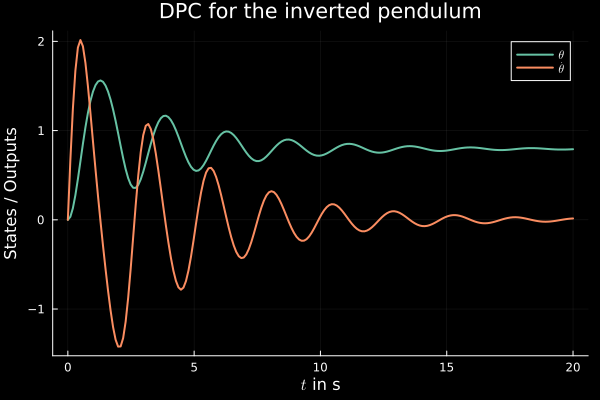

In [14]:
plot(tsteps, predict(res.u)', background_color="#000000", lw=2, palette = :Set2_5, title = "DPC for the inverted pendulum", xlabel = L"$t$ in s", ylabel = "States / Outputs", label=[L"$\theta$" L"$\dot{\theta}$"])

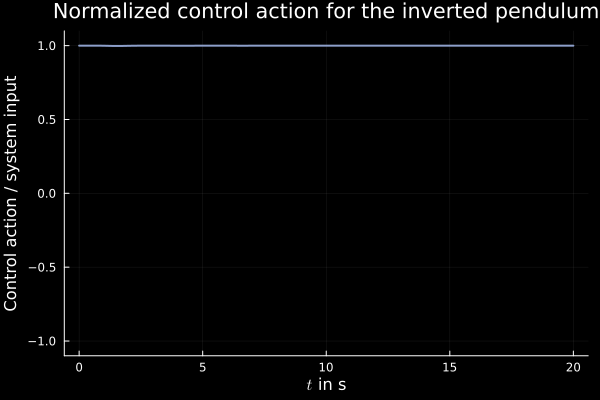

In [15]:
using DataInterpolations
x1_interp = AkimaInterpolation(predict(res.u)[1,:], tsteps)
x2_interp = AkimaInterpolation(predict(res.u)[2,:], tsteps) 
plot(tsteps, map(t -> ann([[x1_interp(t); x2_interp(t)]./ (2*NF(pi)); r(t)./ (2*NF(pi)); ([x1_interp(t); x2_interp(t)] - r(t)) ./ (2*NF(pi)); cos(x1_interp(t))], res.u, st_ANN)[1][1], tsteps), 
    background_color="#000000", lw=2, color = 3, palette = :Set2_5, title = "Normalized control action for the inverted pendulum",
    xlabel = L"$t$ in s", ylabel = "Control action / system input", label = false, ylims = (-1.1, 1.1))

**Observation**: 

The gradient descent style Adam optimizer was not able to find a suitable swing up control policy as it greedily applies the maximum torque to the pendulum, which, however, is not sufficient to achieve the swing up. 

### Finding a suitable starting policy using metaheuristic global optimization

In [16]:
# Add a termination callback to the ODE solver if the pendulum reaches the upper equilibrium point
condition(x, t, integrator) = x[2].^2 < 0.0001 && (x[1] - pi).^2 <  0.0001
affect!(integrator) = terminate!(integrator)
cb_ODE = DiscreteCallback(condition, affect!)

DiscreteCallback{typeof(condition), typeof(affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(condition, affect!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1])

In [17]:
function _predict(w) # redefine prediction function for DPC
    reduce(hcat, solve(prob, Tsit5(), callback = cb_ODE; p = w, saveat = tsteps).u)
end

_predict (generic function with 1 method)

In [18]:
function _loss_DPC(w, p) # redefine loss function for NODE
    buf = _predict(NF.(ComponentArray(w,p)))
    return sum(abs2, (buf - reduce(hcat, r_vec)[:,1:length(buf[1,:])]) .* [1f0; 0.01f0]) # adapt the considered sample time horizon in case the ODE simulation terminates if achieving the upper equilibrium point
end;

In [19]:
# Define modified DPC problem with metaheurstics optimization
using OptimizationBBO, OptimizationMetaheuristics
f_BBO = OptimizationFunction(_loss_DPC)
probBBO =  Optimization.OptimizationProblem(f_BBO, w_ANN, ComponentArrays.getaxes(w_ANN), lb = -2.0ones(size(w_ANN)), ub = 2.0.*(ones(size(w_ANN))))

OptimizationProblem. In-place: true
u0: ComponentVector{Float32}(layer_1 = (weight = Float32[-0.38996613 0.38700292 … 0.047949176 -0.05242225; 0.1227949 0.15600201 … -0.38140258 0.46907443; … ; 0.3117772 -0.2138965 … 0.29043776 -0.19646175; -0.12476748 0.39384925 … 0.449395 -0.45496142], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[0.4837877 -0.083912164 … -0.39592487 -0.4915071], bias = Float32[0.0;;]))

In [20]:
# Solve modified DPC problem with particle swarm optimization (PSO)
sol = solve(probBBO, PSO(N = 4000), seed = Int(42), maxtime = 400.0);

In [21]:
# Inspect the results
sol.original

Optimization Result
===================
  Iteration:       16
  Minimum:         143.296
  Minimizer:       [1.97452, 2, 1.11418, …, 0.873066]
  Function calls:  64000
  Total time:      415.2480 s
  Stop reason:     Maximum time exceeded.

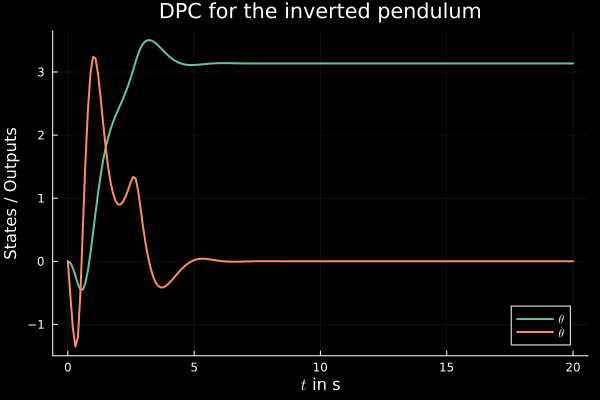

In [22]:
buf = predict(NF.(ComponentArray(sol.u, ComponentArrays.getaxes(w_ANN))))
plot(tsteps[1:length(buf[1,:])], buf', background_color="#000000", lw=2, palette = :Set2_5, title = "DPC for the inverted pendulum", xlabel = L"$t$ in s", ylabel = "States / Outputs", label=[L"$\theta$" L"$\dot{\theta}$"])

**Observation**:

The global metaheuristic optimizer has found a better control policy parameter set such that the swing up can be achieved. However, the control response seems not yet ideal.

### Fine tuning using gradient descent optimization

Next, we will utilize the best parameter set from the above metaheuristic optimization as an informed starting point for another gradient descent optimization using Adam. 

In [23]:
_optprob = Optimization.OptimizationProblem(optf, NF.(ComponentArray(sol.u, ComponentArrays.getaxes(w_ANN)))); # Utilize the optimized parameters from the metaheuristic optimization as initial guess for the DPC optimization problem
_res = Optimization.solve(_optprob, Adam(0.005);   maxiters=1000, maxtime = 120.0, callback=callback_online) # solve optimization problem for DPC

Current loss after 550 iterations: 138.10141
Current loss after 600 iterations: 135.2788
Current loss after 650 iterations: 134.02924
Current loss after 700 iterations: 133.45071
Current loss after 750 iterations: 133.01102
Current loss after 800 iterations: 132.67157
Current loss after 850 iterations: 132.39319
Current loss after 900 iterations: 132.16693
Current loss after 950 iterations: 131.97946
Current loss after 1000 iterations: 131.8234
Current loss after 1050 iterations: 131.68451
Current loss after 1100 iterations: 131.57115
Current loss after 1150 iterations: 131.4782
Current loss after 1200 iterations: 131.3919
Current loss after 1250 iterations: 131.33035
Current loss after 1300 iterations: 131.27837
Current loss after 1350 iterations: 131.22633
Current loss after 1400 iterations: 131.19159
Current loss after 1450 iterations: 131.14867
Current loss after 1500 iterations: 131.11612


u: ComponentVector{Float32}(layer_1 = (weight = Float32[1.7616246 -1.2913506 … 2.708647 1.5653918; 2.00073 -1.526453 … -1.0467883 0.57924926; … ; -4.525792 1.6678277 … -0.63318235 -0.22585486; -0.6777529 -2.007551 … 1.7089843 -1.9672292], bias = Float32[-2.3909855; 2.5036902; … ; -1.1947532; -2.0061655;;]), layer_2 = (weight = Float32[2.0184932 1.5518082 … 2.238385 0.72100997], bias = Float32[0.84671706;;]))

Finally, let's plot the fine-tuned control policy results.

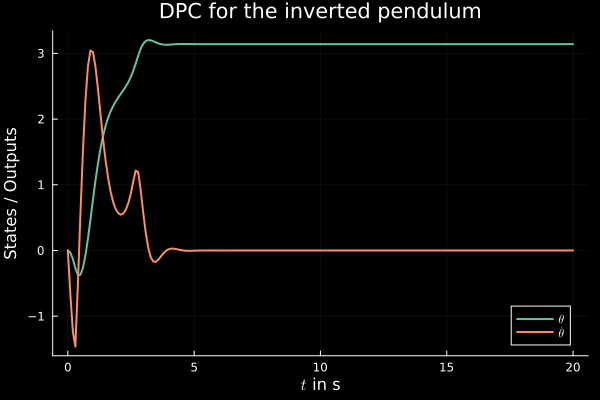

In [24]:
plot(tsteps, predict(_res.u)', background_color="#000000", lw=2, palette = :Set2_5, title = "DPC for the inverted pendulum", xlabel = L"$t$ in s", ylabel = "States / Outputs", label=[L"$\theta$" L"$\dot{\theta}$"])

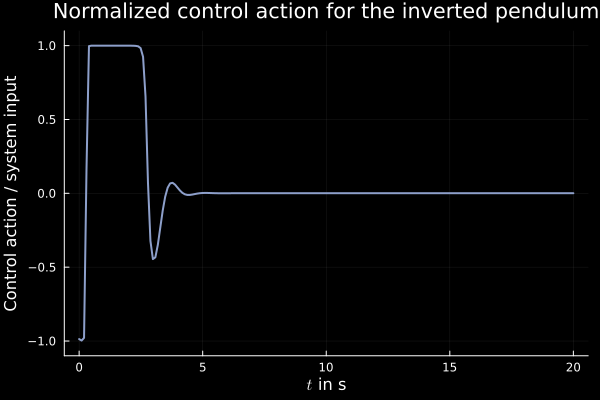

In [25]:
_x1_interp = AkimaInterpolation(predict(_res.u)[1,:], tsteps)
_x2_interp = AkimaInterpolation(predict(_res.u)[2,:], tsteps) 
plot(tsteps, map(t -> ann([[_x1_interp(t); _x2_interp(t)]./ (2*NF(pi)); r(t)./ (2*NF(pi)); ([_x1_interp(t); _x2_interp(t)] - r(t)) ./ (2*NF(pi)); cos(_x1_interp(t))], _res.u, st_ANN)[1][1], tsteps), 
    background_color="#000000", lw=2, color = 3, palette = :Set2_5, title = "Normalized control action for the inverted pendulum",
    xlabel = L"$t$ in s", ylabel = "Control action / system input", label = false, ylims = (-1.1, 1.1))